<a href="https://colab.research.google.com/github/vaniseth/Universal-Gans-Minor-1/blob/main/gan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from zipfile import ZipFile
file_name = "/content/images.zip"

with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('Done')

FileNotFoundError: [Errno 2] No such file or directory: '/content/images.zip'

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
  1%|          | 3/242 [02:56<3:53:56, 58.73s/it]


KeyboardInterrupt: ignored

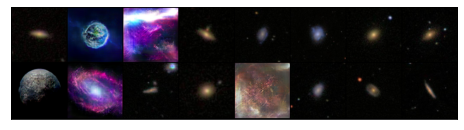

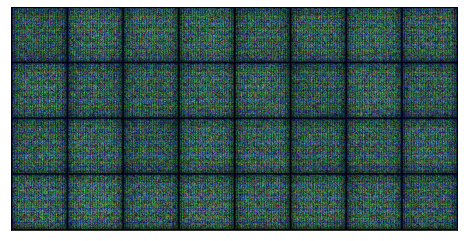

In [ ]:
# Taking the image as input and generating a new image raw image.

import os
import pandas as pd
from pathlib import Path
import torch
import torchvision
import torch.nn as nn
from tqdm import tqdm
import torch.nn.functional as F
import matplotlib.pyplot as plt
from IPython.display import Image
import torchvision.transforms as T
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
from torchvision.utils import save_image

DATA_DIR = "/content/images"

stats = (.5, .5, .5), (.5, .5, .5)

transform_ds = T.Compose([
    T.Resize((128, 128)),
    T.CenterCrop(128),
    T.RandomHorizontalFlip(),
    T.RandomVerticalFlip(),
    T.ToTensor(),
    T.Normalize(*stats)
])
ds = torchvision.datasets.ImageFolder(root=DATA_DIR, transform=transform_ds)


def denorm(img_tensor):
    return img_tensor * stats[1][0] + stats[0][0]


batch_size = 16

train_dl = DataLoader(ds, batch_size, shuffle=True,
                      num_workers=3, pin_memory=True)


def show_image(train_dl):
    for images, _ in train_dl:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(
            make_grid(denorm(images.detach()[:32]), nrow=8).permute(1, 2, 0))
        break


show_image(train_dl)


def get_device():
    if torch.cuda.is_available():
        return torch.device("cuda")
    else:
        return torch.device("cpu")


def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)


class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        for x in self.dl:
            yield to_device(x, self.device)

    def __len__(self):
        return len(self.dl)


device = get_device()

train_dl = DeviceDataLoader(train_dl, device)

discriminator = nn.Sequential(
    #in: 128 x 3 x 128 x 128

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    #128 x 64 x 64 x 64

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    #128 x 128 x 32 x 32

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    #128 x 256 x 16 x 16

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    #128 x 512 x 8 x 8

    nn.Conv2d(512, 1024, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(1024),
    nn.LeakyReLU(0.2, inplace=True),
    #128 x 1024 x 4 x 4

    nn.Conv2d(1024, 1, kernel_size=4, stride=1, padding=0, bias=False),
    #128 x 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid()

)

discriminator = to_device(discriminator, device)

latent_size = 128
generator = nn.Sequential(
    #in: 128 x 1 x 1

    nn.ConvTranspose2d(latent_size, 1024, kernel_size=4,
                       stride=1, padding=0, bias=False),
    nn.BatchNorm2d(1024),
    nn.ReLU(True),
    #128 x 1024 x 4 x 4

    nn.ConvTranspose2d(1024, 512, kernel_size=4,
                       stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    #128 x 512 x 8 x 8

    nn.ConvTranspose2d(512, 256, kernel_size=4,
                       stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    #128 x 256 x 16 x 16

    nn.ConvTranspose2d(256, 128, kernel_size=4,
                       stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    #128 x 128 x 32 x 32

    nn.ConvTranspose2d(128, 64, kernel_size=4,
                       stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    #128 x 64 x 64 x 64

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    #128 x 3 x 128 x 128
    nn.Tanh()


)


generator = to_device(generator, device)


def train_discriminator(real_images, opt_d):
    opt_d.zero_grad()

    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()

    latent = torch.randn(latent_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    fake_preds = discriminator(fake_images)
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    loss = real_loss + fake_loss
    loss.backward(),
    opt_d.step()

    return loss.item(), real_score, fake_score


def train_generator(opt_g):
    opt_g.zero_grad()

    latent = torch.randn(latent_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    preds = discriminator(fake_images)
    targets = torch.ones(fake_images.size(0), 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)

    loss.backward(),
    opt_g.step()

    return loss.item()


sample_dir = "generated"
os.makedirs(sample_dir, exist_ok=True)


def save_sample(index, fixed_latent, show=True):
    fake_images = generator(fixed_latent)
    fake_fname = "generated-images-{0:0=4d}.png".format(index)
    save_image(denorm(fake_images), os.path.join(
        sample_dir, fake_fname), nrow=8)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach()
                  [:32], nrow=8).permute(1, 2, 0))


fixed_latent = torch.randn(128, latent_size, 1, 1, device=device)
save_sample(0, fixed_latent, show=True)


def fit(epochs, lr_d, lr_g, start_idx=1):
    torch.cuda.empty_cache()

    losses_d = []
    losses_g = []
    real_scores = []
    fake_scores = []

    opt_d = torch.optim.Adam(discriminator.parameters(),
                             lr=lr_d, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(),
                             lr=lr_g, betas=(0.5, 0.999))

    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            loss_d, real_score, fake_score = train_discriminator(
                real_images, opt_d)
            loss_g = train_generator(opt_g)

        losses_d.append(loss_d)
        losses_g.append(loss_g)
        real_scores.append(real_score)
        fake_scores.append(fake_score)

        print("Epoch: [{}/{}], loss_d: {:.4f}, loss_g: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_d, loss_g, real_score, fake_score))

        save_sample(epoch+start_idx, fixed_latent, show=False)

    return losses_d, losses_g, real_scores, fake_scores


epochs = 20
lr_d = 10e-5
lr_g = 10e-4

history = [fit(epochs, lr_d, lr_g, start_idx=1)]